# $\S 1.1$ Solutions of linear equations system
---

In this lab, I will test three algorithms of solving linear equations system about their correctness and efficiency, they are: 
- Principle Component Method
- Jacobi Iteration ALgorithm
- Gauss-Seidel Iteration Algorithm  
And then use these algorithms to solve the problem 1, 2 in instruction book. 

## 1. realization of these algorithms 

In [3]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy import linalg

## 1.0. preparation 
calcualte 'B' matrix of jacobi and GS, and calculate loss of algorithm: 
$$
let\ \ A = L+D+U \tag{1}
$$
### 1.0.1. Jacobi:
$$
x^{(k+1)}=\underbrace{\boxed{-D^{-1}(L+U)}}_{B_{Jacobi}}x^{(k)}+D^{-1}b \tag{2}
$$

In [4]:
def jacobi_B_g(A, b):  # calculate B firstly and then calculate g 
    D = np.diag(np.diag(A))
    L_U = A - D
    D_inv = np.linalg.inv(D)
    B = -D_inv @ L_U
    g = D_inv @ b
    return B, g

### 1.0.2. Gauss-Seidel: 
$$
x^{(k+1)}=\underbrace{\boxed{-(L+D)^{-1}U}}_{B_{GS}}x^{(k)}+(L+D)^{-1}b \tag{3}
$$

In [5]:
def gauss_seidel_B_g(A, b):  # calculate B firstly and then calculate g 
    D = np.diag(np.diag(A))
    L = np.tril(A, -1)
    U = np.triu(A, 1)
    D_L_inv = np.linalg.inv(D + L)
    B = -D_L_inv @ U
    g = D_L_inv @ b
    return B, g

### 1.0.3. Loss: $e(x^{k})$

To compare the two iteration method we choose the norm difference as the loss of our algorihtm: 
given iteration fomular of simple iteration method 1 & 2:
$$
x^{(k+1)} = Bx^{(k)} + g \tag{4}
$$
we get: 
$$
e(x^{(k)}) = {||B||\over 1-||B||} ||x^{(k)}-x^{(k-1)}|| \tag{5}
$$
proof is given in ppt of the course. 

In [8]:
def loss(B, x_new, x):
    """
    Calculates the loss of x_new (norm 2 here)

    Args:
    - B: numpy array of shape (n,)
    - x_new: numpy array of shape (n,)
    - x: numpy array of shape (n,)

    Returns:
    - float representing the loss
    """
    
    norm_B = np.linalg.norm(B, 2)  # calculate the norm of B
    if norm_B >= 1:  # if norm of B is greater than 1, the algorithm may not converge 
        return -1
    diff_x = np.linalg.norm(x_new - x, 2)  # calculate the norm of the difference between x_new and x
    error = norm_B / (1 - norm_B) * diff_x
    return abs(error)

### 1.1. Principle Component Method (optimization of gauss elimination method)

In [7]:
def PCM(A, b):
    """
    Performs Gaussian elimination on the system of linear equations Ax = b,
    where A is an n x n matrix and b is an n-dimensional vector.
    
    Args:
    - A: numpy array of shape (n, n) representing the coefficient matrix
    - b: numpy array of shape (n,) representing the constant vector
    
    Returns:
    - numpy array of shape (n,) representing the solution vector x
    """
    n = len(A)
    M = A.copy()
    b_copy = b.copy()
    
    for k in range(n):
        # find principle element 
        maxindex = abs(M[k:,k]).argmax() + k
        
        # swap 
        if k != maxindex:
            M[[k,maxindex]] = M[[maxindex, k]]
            b_copy[[k,maxindex]] = b_copy[[maxindex, k]]
            
        # elimination 
        for row in range(k+1, n):
            multiplier = M[row][k]/M[k][k]
            M[row][k:] = M[row][k:] - multiplier*M[k][k:]
            b_copy[row] = b_copy[row] - multiplier*b_copy[k]
    
    # back substitution
    x = np.zeros(n)
    for k in range(n-1, -1, -1):
        x[k] = (b_copy[k] - np.dot(M[k,k+1:], x[k+1:])) / M[k,k]
    return x

### 1.2. Jacobi Iteration (simple iteration method)

iteration formular: 
$$
x_{i}^{(k+1)} = {{b_{i} - \sum_{j=1}^{i-1} A_{ij} x_{j}^{(k)} - \sum_{j=i+1}^{n} A_{ij} x_{j}^{(k)}} \over A_{ii}} \tag{6}
$$

In [9]:
def jacobi(A, b, tol=1e-6, max_iter=1000):
    """
    Performs Jacobi iteration on the system of linear equations Ax = b,
    where A is an n x n matrix and b is an n-dimensional vector.
    
    Args:
    - A: numpy array of shape (n, n) representing the coefficient matrix
    - b: numpy array of shape (n,) representing the constant vector
    - tol: float representing the tolerance for convergence
    - max_iter: int representing the maximum number of iterations

    Returns:
    - numpy array of shape (n,) representing the solution vector x
    - list of float representing the norm of the difference between x_new and x
    """
    n = len(b)
    x = np.zeros(n)
    ll = []
    x_new = np.zeros(n)
    B, _ = jacobi_B_g(A, b)

    # if loss(B, x_new, x) >= 0:  # not converge
    #     raise ValueError('Jacobi method may not converge')

    for _ in range(max_iter):
        for i in range(n):
            # calculate x_new
            x_new[i] = (b[i] - np.dot(A[i, :i], x[:i]) - np.dot(A[i, i+1:], x[i+1:])) / A[i, i] 

        iloss = loss(B, x_new, x)
        ll.append(iloss)  # calculate the error by the norm of the difference between x_new and x
        if iloss < tol:  # check if the error is less than the tolerance
            break
        x = np.copy(x_new)
    return x, ll

### 1.3. Gauss Seidel (optimized iteration method)
iteration formular: 
$$
x_{i}^{(k+1)} = {{b_{i} - \sum_{j=1}^{i-1} A_{ij} x_{j}^{(k)} - \sum_{j=i+1}^{n} A_{ij} x_{j}^{(k+1)}} \over A_{ii}} \tag{7}
$$

In [10]:
def gauss_seidel(A, b, tol=1e-6, max_iter=1000):
    """
    Performs Gauss-Seidel iteration on the system of linear equations Ax = b,
    where A is an n x n matrix and b is an n-dimensional vector.
    
    Args:
    - A : numpy array of shape (n, n) representing the coefficient matrix
    - b : numpy array of shape (n,) representing the constant vector
    - tol : float representing the tolerance for convergence
    - max_iter : int representing the maximum number of iterations

    Returns:
    - numpy array of shape (n,) representing the solution vector x
    - list of float representing the norm of the difference between x_new and x
    """
    n = len(b)
    x = np.zeros(n)
    ll = []
    x_new = np.zeros(n)
    B, _ = gauss_seidel_B_g(A, b)

    # if loss(B, x_new, x) < 0: # not converge
    #     raise ValueError('Gauss-Seidel method may not converge')

    for _ in range(max_iter):
        for i in range(n):
            # calculate x_new
            x_new[i] = (b[i] - np.dot(A[i, :i], x_new[:i]) - np.dot(A[i, i+1:], x[i+1:])) / A[i, i] 

        iloss = loss(B, x_new, x)
        ll.append(iloss)  # calculate the error by the norm of the difference between x_new and x
        if iloss < tol:  # check if the error is less than the tolerance
            break
        x = np.copy(x_new)
    return x, ll

I will use the loss as metric to visualize the convergency of algorithm. 

In [11]:
def visualize(A, b):
    plt.figure(figsize=(12, 6))
    _, ll2 = jacobi(A, b)
    _, ll3 = gauss_seidel(A, b)
    plt.plot(np.arange(len(ll2)), np.array(ll2), label='Jacobi')
    plt.plot(np.arange(len(ll3)), np.array(ll3), label='Gauss-Seidel')
    plt.ylabel('Loss')
    plt.xlabel('Iteration')
    plt.title('Convergency of Jacobi and Gauss-Seidel')
    plt.legend()
    plt.tight_layout()
    plt.show()

## 2. test and analysis of these algorithms

To test these algorithms, we use linear solver in well-tested package of python 'scipy' to calculate the same linear equations and compare the results. 

here is an example: 

In [12]:
# Coefficient matrix and constant vector
A = np.array([
        [3.18646561, 0.95071431, 0.73199394, 0.59865848, 0.15601864],
        [0.15599452, 2.44752548, 0.86617615, 0.60111501, 0.70807258],
        [0.02058449, 0.96990985, 3.04954371, 0.21233911, 0.18182497],
        [0.18340451, 0.30424224, 0.52475643, 2.16752236, 0.29122914],
        [0.61185289, 0.13949386, 0.29214465, 0.36636184, 2.32199322]])
b = np.array(
        [0.78517596, 0.19967378, 0.51423444, 0.59241457, 0.04645041])

# Solution
sol0 = linalg.solve(A, b)  # control group

sol1 = PCM(A, b)  # exercise group
sol2, _ = jacobi(A, b)
sol3, _ = gauss_seidel(A, b)

# Results
np.set_printoptions(precision=7, floatmode='fixed')
print(f'Solution             : {sol0}')
print(f'PCM solution         : {sol1}')
print(f'Jacobi solution      : {sol2}')
print(f'Gauss-Seidel solution: {sol3}')

Solution             : [ 0.1754365 -0.0206160  0.1626760  0.2330266 -0.0822191]
PCM solution         : [ 0.1754365 -0.0206160  0.1626760  0.2330266 -0.0822191]
Jacobi solution      : [ 0.1754364 -0.0206161  0.1626759  0.2330265 -0.0822191]
Gauss-Seidel solution: [ 0.1754363 -0.0206163  0.1626760  0.2330265 -0.0822190]


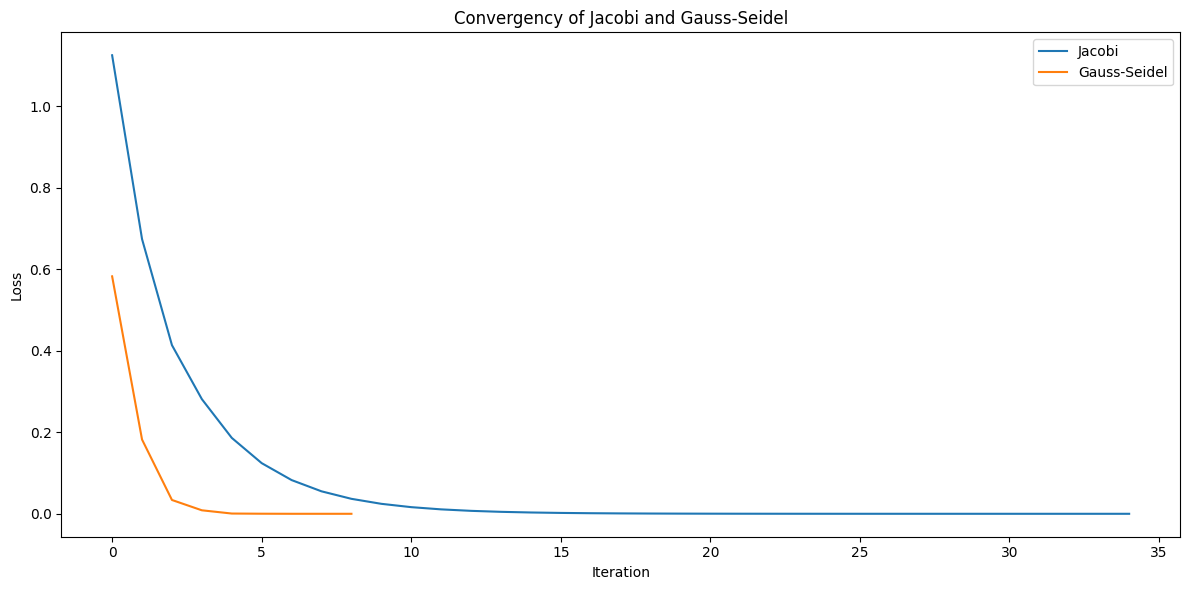

In [13]:
# Visualization of iteration methods
visualize(A, b)

<center>  


**Figure 1.** comparison between Jacobi Algorithm and Gauss-Seidel Algorithm

as we can see from the result, PCM method get the precise solution and the latter two get the approximate solution. And from the **Figure 1**, we can see that Jacobi Method convergences slower than the Gauss-Seidel Method. 



$\underline{Further more}$, I guess that the advantages will be more obvious with the incresing of data scale. So, I will test it by random matrix. 
***Firstly***, we should make sure the matrix is soluble. Here is a lamma that if a matrix is diagonal dominance, we can get the iteration solution 100% under simple iteration methods. So, to make it convergence 100%, we add a constant $p - 1$ to diagonal elements. Here is the proof:   
$Given\ that\ the\ value\ our\ generated\ matrix\ is\ in\ interval\ (0,1),\ so\ we\ get:$
$$
|\sum_{k=0}^{i-1}A_{kj}+\sum_{k=i+1}^{n}A_{kj}| \lt p - 1 \lt |A_{ii}| + p - 1 = |A_{ii}^{'}| \\
\Rightarrow |\sum_{k=0}^{i-1}A_{kj}^{'}+\sum_{k=i+1}^{n}A_{kj}^{'}| \lt |A_{ii}^{'}| \tag{8}
$$
  

In [116]:
def generate_solvable_linear_systems(sol, p=4):
    """ 
    Generates n random solvable linear systems of size p x p with given solution 'sol'
    """
    A = np.random.rand(p, p)
    A += np.diag(np.random.rand(p) + p - 1)  # make A seriously diagonally dominant 
    b = A @ sol  # calculate b
    return A, b

let's have a test: 

In [117]:
sol = np.random.rand(5)
print(sol)
A, b = generate_solvable_linear_systems(sol, p=5) 
s0 = PCM(A, b)
print(s0)
s2, ll2= jacobi(A, b)
print(s2)
print(ll2)

[0.3257129 0.0892660 0.6329342 0.8827439 0.0461108]
[0.3257129 0.0892660 0.6329342 0.8827439 0.0461108]
[0.3257131 0.0892662 0.6329344 0.8827440 0.0461109]
[1.0729279367171034, 0.38483224122419896, 0.16459246398279687, 0.06975825961052158, 0.029603854072819718, 0.012578693764946849, 0.005341235591093518, 0.0022687063576612076, 0.0009635361601440568, 0.0004092358957212086, 0.00017380981396116467, 7.382041576552628e-05, 3.135293267893757e-05, 1.3316191013985973e-05, 5.655640665727859e-06, 2.402058717759389e-06, 1.020200245365305e-06, 4.332985446188235e-07]


**then**, we do 6 experiments under different random seeds to proof our experiment is repeatable. Each experiment we will test the algorithm of different level(range 2 ~ 21). For each level, we choose 50 different seeds for random solution vector, and generate 100 different coefficient matries, and finally average the iteration for each solution vector. 

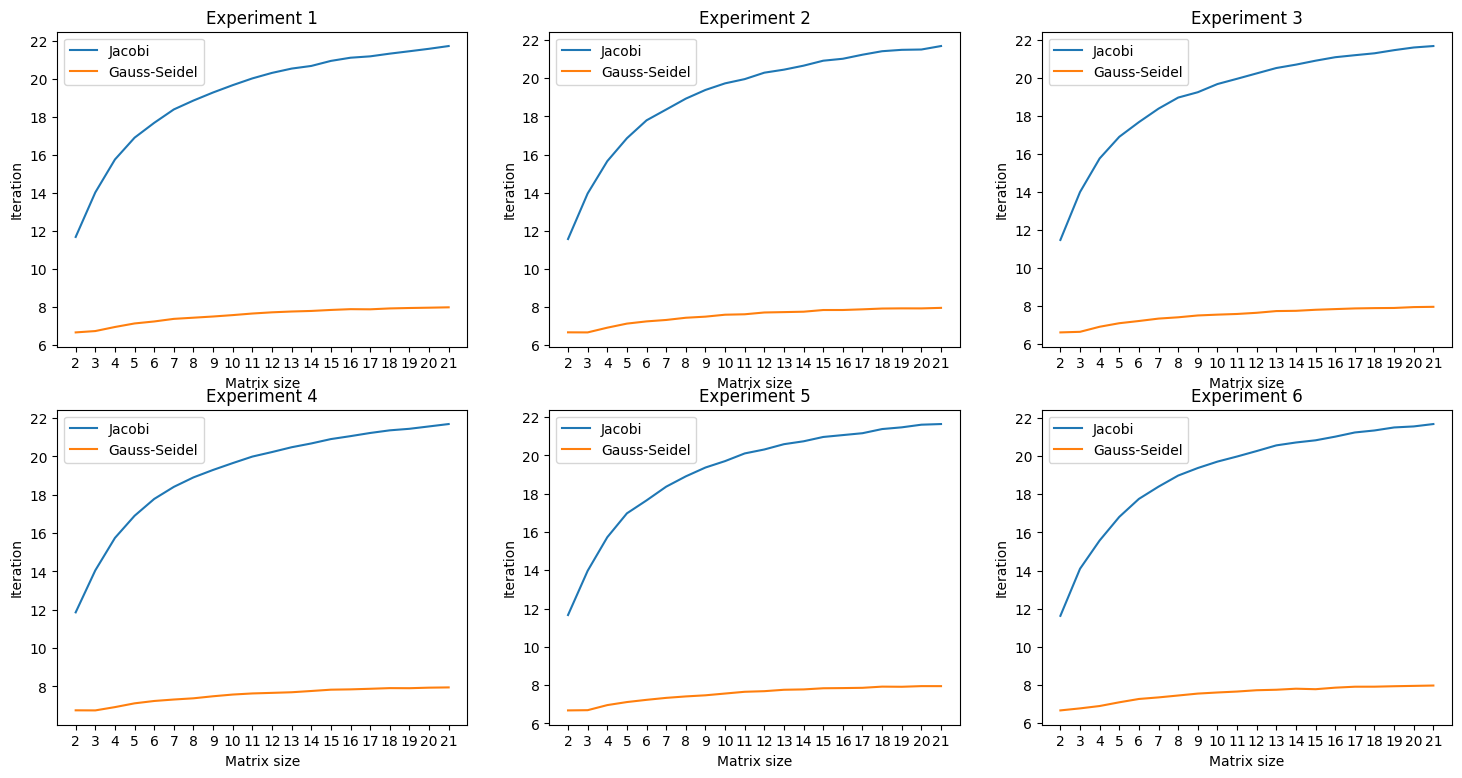

In [118]:
seed_num = 50
mat_num = 100
equation_range = (2, 22)  # p = 2 ~ 21 range


fig, axs = plt.subplots(2, 3, figsize=(18, 9))
for i in range(6): # complete 6 experiments 
    np.random.seed(int(np.random.rand() * 1000000))  # set random seed
    iter_times_jacobi = []
    iter_times_gauss_seidel = []
    falut_count = []

    for j in range(equation_range[0], equation_range[1]):  # p = 2 ~ 21
        l2 = []
        l3 = []
        facnt = 0

        for _ in range(seed_num): 
            # for each solution vector do following operation 
            ll2 = []
            ll3 = []
            ffacnt = 0

            sol = np.random.rand(j)
            for _ in range(mat_num):
                A, b = generate_solvable_linear_systems(sol, p=j)  # generate random linear systems
                s2, lll2 = jacobi(A, b)
                s3, lll3 = gauss_seidel(A, b)
                if np.mean(s2 - sol) < 1e-6 and np.mean(s3 - sol) < 1e-6:  # converge
                    ll2.append(len(lll2))
                    ll3.append(len(lll3))
                else:
                    ffacnt += 1  # if not converge under the given tolerance, 1e-6 here, falut_count += 1

            if len(ll2) != 0 and len(ll3) != 0: # if l2 or l3 is empty, mean will return nan, so if l2 or l3 is empty, we abandon this solution
                l2.append(np.mean(ll2))
                l3.append(np.mean(ll3))
                facnt += ffacnt

        iter_times_jacobi.append(np.mean(l2))
        iter_times_gauss_seidel.append(np.mean(l3))
        falut_count.append(facnt)

    a, b = i//3, i%3
    axs[a, b].plot(np.arange(2, len(iter_times_jacobi) + 2), np.array(iter_times_jacobi), label='Jacobi')
    axs[a, b].plot(np.arange(2, len(iter_times_gauss_seidel) + 2), np.array(iter_times_gauss_seidel), label='Gauss-Seidel')
    axs[a, b].set_xticks(np.arange(2, len(iter_times_jacobi) + 2, 1))
    axs[a, b].set_ylabel('Iteration')
    axs[a, b].set_xlabel('Matrix size')
    # axs[a, b].set_title('Convergency iterations of Jacobi and Gauss-Seidel, experiment {}'.format(i+1))
    axs[a, b].set_title('Experiment {}'.format(i+1))
    axs[a, b].legend()

plt.show()

<center>  


**Figure 2.** average iteration number increasing with matrix size

As we can see in **Figure 2**, the GS algorithm always performs well than Jacobi algorithm. And the scaling of iteration numbers is not so shaply with GS algorithm.  
(2024.4.13 add) From the result we can find the experiment is repeatable. And I guess that the iteration may equals the log scale of matrix size. 

# 3. solution of problems 

## 3.1. problem 1

In [119]:
A = np.array([[1.1348, 3.8326, 1.1651, 3.4017],
              [0.5301, 1.7875, 2.5330, 1.5435],
              [3.4129, 4.9317, 8.7643, 1.3142],
              [1.2371, 4.9998, 10.6721, 0.0147]])
b = np.array([9.5342, 6.3941, 18.4231, 16.9237])

# Solution
sol0 = linalg.solve(A, b)  # control group

sol1 = PCM(A, b)  # exercise group

# Results
np.set_printoptions(precision=7, floatmode='fixed')
print(f"Solution             : {sol0}")
print(f"PCM solution         : {sol1}")


Solution             : [1.0000000 1.0000000 1.0000000 1.0000000]
PCM solution         : [1.0000000 1.0000000 1.0000000 1.0000000]


## 3.2. Problem 2

Solution             : [1.1000000 1.2000000 1.3000000]
PCM solution         : [1.1000000 1.2000000 1.3000000]
Jacobi solution      : [1.0999992 1.1999992 1.2999990]
Gauss-Seidel solution: [1.0999983 1.1999989 1.2999994]


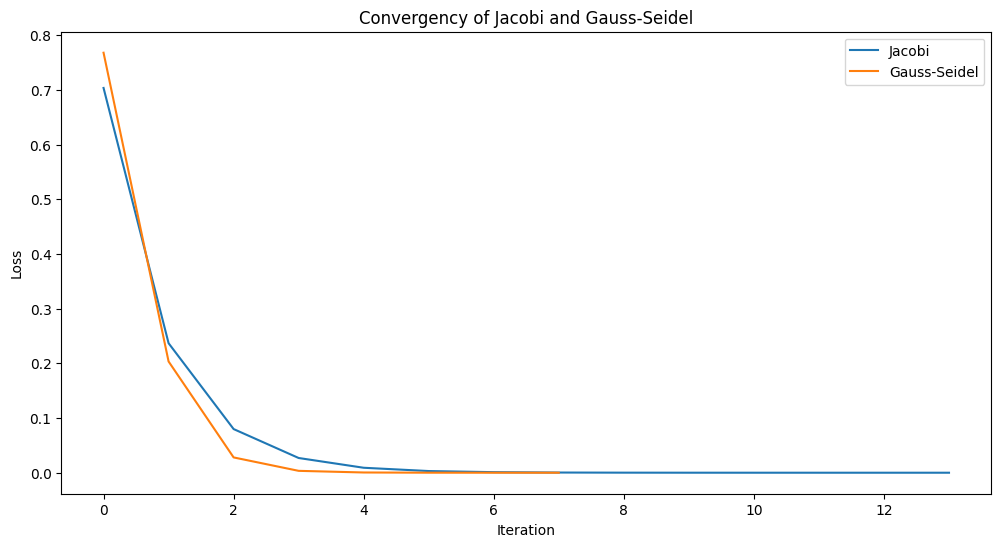

In [120]:

A = np.array([[10, -1, -2.0],
              [-1, 10, -2],
              [-1, -1, 5]])
b = np.array([7.2, 8.3, 4.2])

# Solution
sol0 = linalg.solve(A, b)  # control group

sol1 = PCM(A, b)  # exercise group
sol2, _ = jacobi(A, b)
sol3, _ = gauss_seidel(A, b)

# Results
np.set_printoptions(precision=7, floatmode='fixed')
print(f'Solution             : {sol0}')
print(f'PCM solution         : {sol1}')
print(f'Jacobi solution      : {sol2}')
print(f'Gauss-Seidel solution: {sol3}')

visualize(A, b)

<center>  


**Figure 3.** comparison between Jacobi Algorithm and Gauss-Seidel Algorithm of Problem 2